<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/MFK/SMT_MFEGO.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Multifidelity Notebook  -  Educational Bayesian Optimization 

July 2025
SMT version 2.9.3

<div class="jumbotron text-left"><b>
This notebook describes how to use the MFEGO algorithm, which is a python toolbox for solving an optimization problem with multifidelity sources. This tutorial uses SMT toolbox with multifidelity data to build a surrogate model or perform a multifidelity  optimization.</b></div>

Authors : 
- Nathalie BARTOLI ONERA/DTIS/M2CI 
- Thierry LEFEBVRE ONERA/DTIS/M2CI 

with contributions from

- Mostafa Meliani former ISAE-SUPAERO student
- Rémy Priem former ISAE-SUPAERO - ONERA PhD student
- Alejandro Diaz Bolivar former ONERA student 
- Rémy Charayron current ISAE-SUPAERO - ONERA PhD student
- Andres Lopez-Lopera - ONERA Post Doc


## About SMT toolbox
<div class="alert alert-info" id="d110">
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.
    
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
     
</div>

###### Objectives of the Lab session
<div class="alert alert-success">

<p> 1D given examples</p>
<ol> -  build 1D surrogate models from 2 fidelity levels: mono and fidelity  </ol>
<ol> -  optimize 1D function with 2 fidelity levels: mono and multifidelity in order to compare EGO and MFEGO  </ol> 
    A reference solution is obtained with a gradient based optimizer (SLSQP).
<p> Proposed Exercices </p>
<ol> -  approximate a 1D function with 3 fidelity levels: compare mono and multifidelity models </ol>
<ol> -  optimize the 2D Branin function: compare EGO  and MFEGO   </ol>  
<ol> -  optional: optimize the 2D Rosenbrock function: compare EGO and MFEGO  </ol>    
</div>

In [77]:
import warnings

warnings.filterwarnings("ignore")

In [78]:
from IPython.display import Image

# Multi-Fidelity Kriging and Optimization

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use Le Gratiet recursive formulation of multi-fidelity Kriging.

<p class="alert alert-warning" style="padding:1em">
An important assumption by using this recursive formulation is the nested DOE. 
If we have two fidelity levels (HF and LF)
$$X_{HF} \subset X_{LF}$$
 </p>   

### Kennedy O'Hagan/Le Gratiet recursive formulation:
To perform Le Gratiet's learning, we first learn the lowest fidelity, then we consecutively learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\delta_k(\cdot)$).

$$\mu_{k} = \rho_{k-1}\;\mu_{k-1} + \mu_{\delta_k}\\
\sigma^2_{k} = \rho_{k-1}^2\;\sigma^2_{k-1}+\sigma^2_{\delta_k}$$




This generally results in a better surrogate model compared to training the high-fidelity alone.


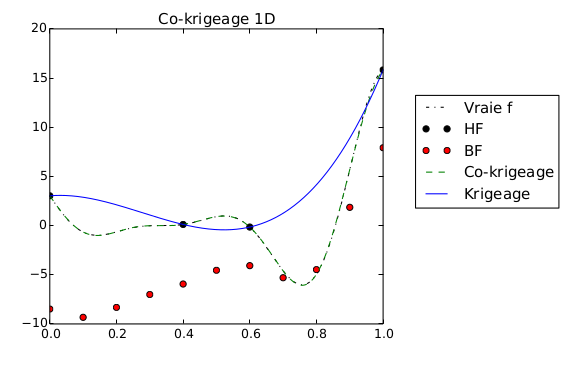

In [79]:
Image(filename="co-krigeage.png")

## 0. SMT Installation
You need to install SMT library from: https://github.com/SMTorg/smt
###google colab
!pip install smt
###or  directly on your computer
import smt

In [80]:
%pip install smt
import smt

print("SMT version", smt.__version__)

SMT version 2.9.3



<p class="alert alert-warning" style="padding:1em">
%matplotlib inline for  google colab instead of %matplotlib notebook
  </p>

In [81]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## 1. RSM building

First let's study the operation of the co-kriging on a 1D test function

Define the analytic function: *Forretal function*. the same function of Forretal LF as the one presented in the following article has been used

>*A radial basis function-based multi-fidelity surrogate model: exploring correlation between high-fidelity and low-fidelity models.* Structural and Multidisciplinary Optimization. 01/04/2019. Xueguan Song, Liye Lv, Wei Sun, Jie Zhang. https://doi.org/10.1007/s00158-019-02248-0

In [82]:
# defining low and high fidelity functions
def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 - 5


def HF_function(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)

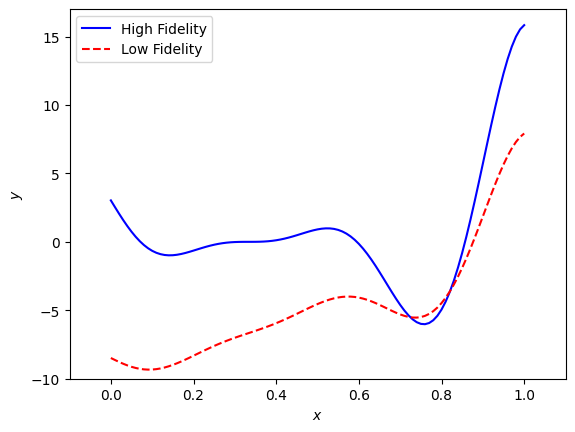

In [83]:
# To plot the 2 analytical functions
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
plt.figure()

plt.plot(x, HF_function(x), "b-", label="High Fidelity")
plt.plot(x, LF_function(x), "r--", label="Low Fidelity")

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

First we need to import nested DOE capability from SMT 

In [84]:
from smt.applications.mfk import NestedLHS

Then let's create  a DOE suitable for multi fidelity

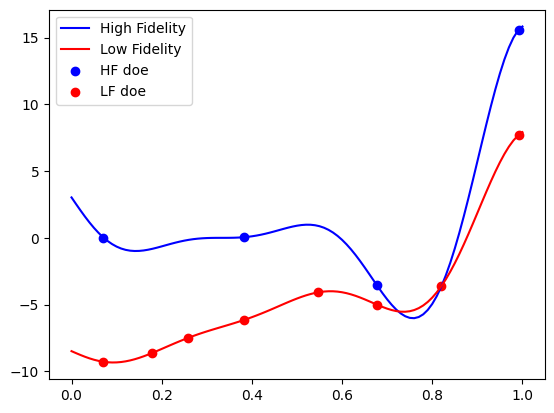

In [85]:
# Dimension
ndim = 1

#  Nested LHS sampling

xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=2, xlimits=xlimits)
Xt_c, Xt_e = xdoes(4)

# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)

# to plot the HF and LF functions
plt.plot(x, HF_function(x), c="b", label="High Fidelity")
plt.plot(x, LF_function(x), c="r", label="Low Fidelity")
plt.scatter(Xt_e, yt_e, marker="o", color="b", label="HF doe")
plt.scatter(Xt_c, yt_c, marker="o", color="r", label="LF doe")
plt.legend(loc=0)
plt.show()

### 1.1 Mono fidelity operation

Let's create 2 mono fidelity RSM (here Kriging)

In [86]:
from smt.surrogate_models import KRG

In [87]:
# Surrogate for the LF function
sm_LF = KRG()
sm_LF.set_training_values(Xt_c, yt_c)
sm_LF.train()

# To plot the surrogate model
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
# query the outputs
y_LF = sm_LF.predict_values(x)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 8
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2448258
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


In [88]:
# Surrogate for the HF function
sm_HF = KRG()
sm_HF.set_training_values(Xt_e, yt_e)
sm_HF.train()

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# query the outputs
y_HF = sm_HF.predict_values(x)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2156212
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


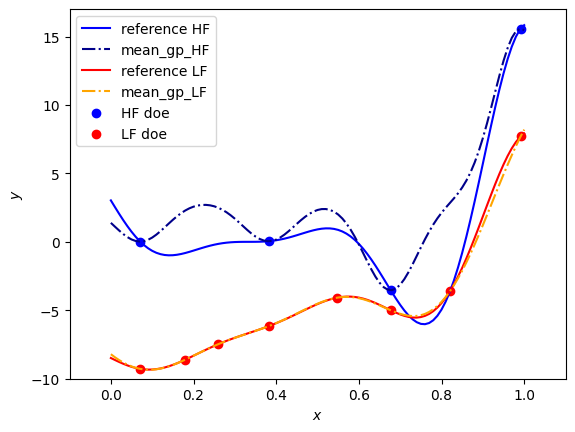

In [89]:
# plot the outputs: functions and associated surrogates
plt.plot(x, HF_function(x), color="b", label="reference HF")
plt.plot(x, y_HF, linestyle="-.", color="darkblue", label="mean_gp_HF")
plt.plot(x, LF_function(x), color="r", label="reference LF")
plt.plot(x, y_LF, linestyle="-.", color="orange", label="mean_gp_LF")
plt.scatter(Xt_e, yt_e, marker="o", color="b", label="HF doe")
plt.scatter(Xt_c, yt_c, marker="o", color="r", label="LF doe")

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [90]:
# Accessing the variance and derivative of the model
MSE_LF = sm_LF.predict_variances(x)
MSE_HF = sm_HF.predict_variances(x)

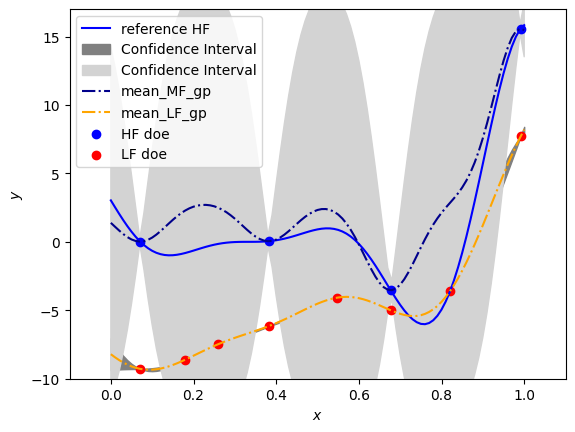

In [91]:
# plot the variance
plt.plot(x, HF_function(x), color="b", label="reference HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y_LF - 2 * np.sqrt(MSE_LF)),
    np.ravel(y_LF + 2 * np.sqrt(MSE_LF)),
    color="grey",
    label="Confidence Interval",
)
plt.fill_between(
    np.ravel(x),
    np.ravel(y_HF - 2 * np.sqrt(MSE_HF)),
    np.ravel(y_HF + 2 * np.sqrt(MSE_HF)),
    color="lightgrey",
    label="Confidence Interval",
)

plt.plot(x, y_HF, linestyle="-.", color="darkblue", label="mean_MF_gp")
plt.plot(x, y_LF, linestyle="-.", color="orange", label="mean_LF_gp")
plt.scatter(Xt_e, yt_e, marker="o", color="b", label="HF doe")
plt.scatter(Xt_c, yt_c, marker="o", color="r", label="LF doe")

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

### 1.2 Multi fidelity operation

In [92]:
from smt.applications import MFK

In [93]:
# %% Build the MFK object
sm_MF = MFK()

# low-fidelity dataset names being integers from 0 to level-1
sm_MF.set_training_values(Xt_c, yt_c, name=0)
# high-fidelity dataset without name
sm_MF.set_training_values(Xt_e, yt_e)

# train the model
sm_MF.train()

# test training
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# query the outputs
y_MF = sm_MF.predict_values(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3506234
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


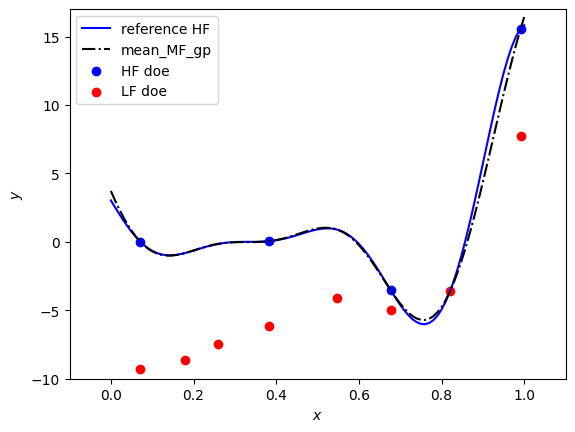

In [94]:
# plot the outputs
plt.plot(x, HF_function(x), color="b", label="reference HF")
plt.plot(x, y_MF, linestyle="-.", color="black", label="mean_MF_gp")
plt.scatter(Xt_e, yt_e, marker="o", color="b", label="HF doe")
plt.scatter(Xt_c, yt_c, marker="o", color="r", label="LF doe")

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [95]:
# Accessing the variance and derivative of the model
MSE = sm_MF.predict_variances(x)

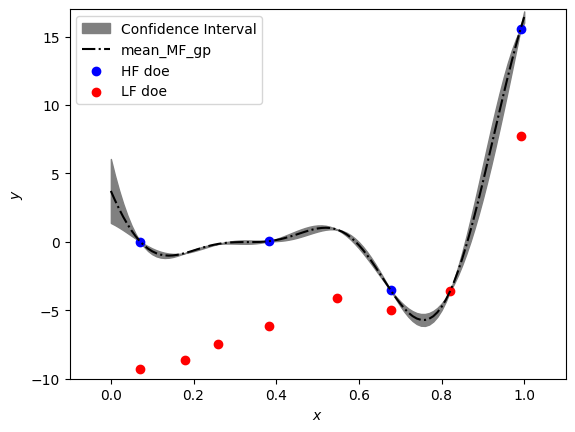

In [96]:
# plot the variance
plt.fill_between(
    np.ravel(x),
    np.ravel(y_MF - 2 * np.sqrt(MSE)),
    np.ravel(y_MF + 2 * np.sqrt(MSE)),
    color="grey",
    label="Confidence Interval",
)
plt.plot(x, y_MF, linestyle="-.", color="black", label="mean_MF_gp")
plt.scatter(Xt_e, yt_e, marker="o", color="b", label="HF doe")
plt.scatter(Xt_c, yt_c, marker="o", color="r", label="LF doe")

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

## 1.3 Exercice with a 1D toy function  and 3 fidelity levels

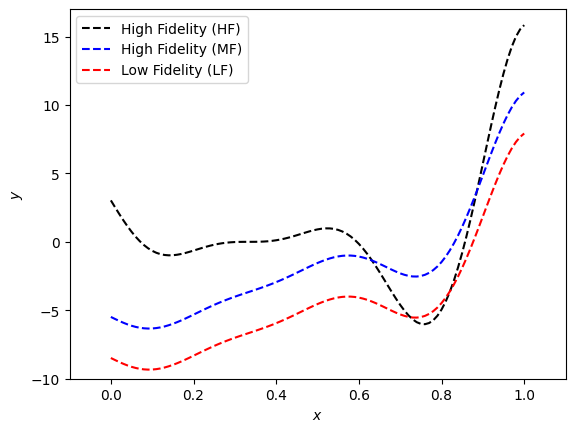

In [97]:
## Exercice 1D with 3 levels
def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 - 5


def MF_function(x):
    return LF_function(x) + 3


def HF_function(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)


x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

plt.figure()
plt.plot(x, HF_function(x), "--k", label="High Fidelity (HF)")
plt.plot(x, MF_function(x), "--b", label="High Fidelity (MF)")
plt.plot(x, LF_function(x), "--r", label="Low Fidelity (LF)")
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

 ### <font color='blue'>Exercice 1:  Create a nested DOE with 3 levels</font>

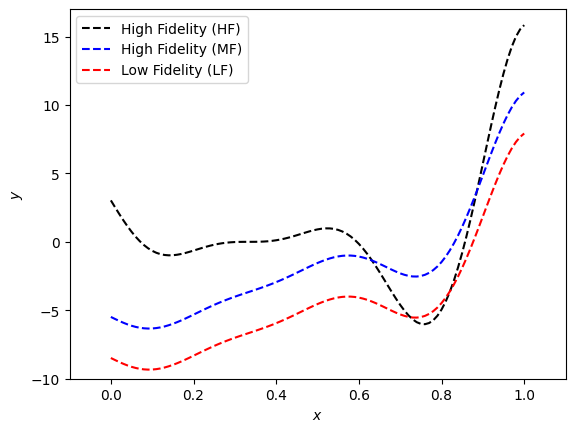

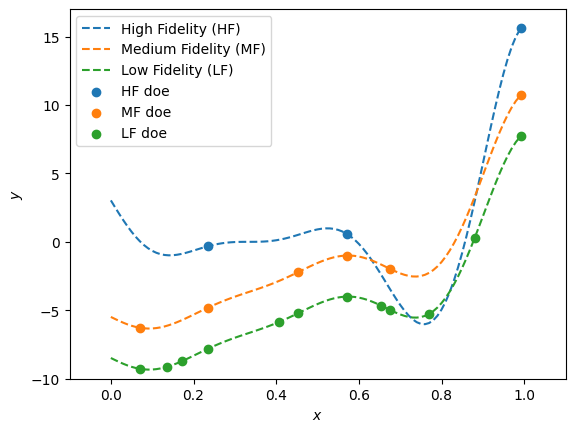

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.7900755
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0016415
   
   Prediction time/pt. (sec) :  0.0000163
   


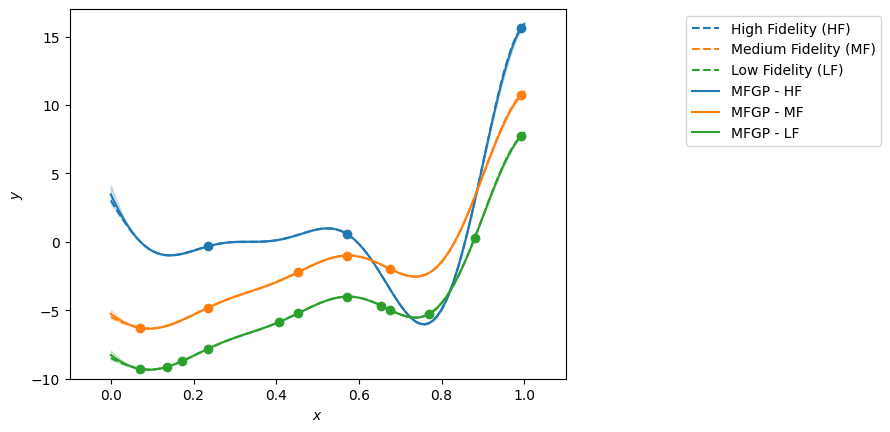

In [98]:
from smt.applications import MFK
import numpy as np
from matplotlib import pyplot as plt
from smt.surrogate_models import KRG
from smt.applications.mfk import NestedLHS


def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 - 5


def MF_function(x):
    return LF_function(x) + 3


def HF_function(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)


x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

plt.figure()
plt.plot(x, HF_function(x), "--k", label="High Fidelity (HF)")
plt.plot(x, MF_function(x), "--b", label="High Fidelity (MF)")
plt.plot(x, LF_function(x), "--r", label="Low Fidelity (LF)")
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()


# LHS sampling
ndim = 1
nlvl = 3

# Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits)
Xt_c, Xt_m, Xt_e = xdoes(3)

# Expensive DOE with 4 points = Xt_e
# Intermediate DOE with 8 points = Xt_m
# Cheap DOE with 16 points Xt_c


# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_m = MF_function(Xt_m)
yt_c = LF_function(Xt_c)


plt.plot(x, HF_function(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, MF_function(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, LF_function(x), "--C2", label="Low Fidelity (LF)")
plt.scatter(Xt_e, yt_e, marker="o", color="C0", label="HF doe")
plt.scatter(Xt_m, yt_m, marker="o", color="C1", label="MF doe")
plt.scatter(Xt_c, yt_c, marker="o", color="C2", label="LF doe")
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()


# %% Build the MFK object with 3 levels
sm = MFK()

# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c, yt_c, name=0)
sm.set_training_values(Xt_m, yt_m, name=1)
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e)
# train the model
sm.train()

# test training
ntest = 101
nlvl = len(sm.X)
x = np.linspace(0, 1, ntest, endpoint=True).reshape(-1, 1)
# query the outputs
y = sm.predict_values(x)
y0 = sm._predict_intermediate_values(x, 1)
y1 = sm._predict_intermediate_values(x, 2)
var = sm.predict_variances(x)
varAll, _ = sm.predict_variances_all_levels(x)
var0 = varAll[:, 0].reshape(-1, 1)
var1 = varAll[:, 1].reshape(-1, 1)

plt.plot(x, HF_function(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, MF_function(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, LF_function(x), "--C2", label="Low Fidelity (LF)")
plt.plot(x, y, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C0",
    alpha=0.2,
)  # ,label ='Confidence Interval 99% HF')
plt.plot(x, y1, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y1 - 3 * np.sqrt(var1)),
    np.ravel(y1 + 3 * np.sqrt(var1)),
    color="C1",
    alpha=0.2,
)  # ,label ='Confidence Interval 99% MF')
plt.plot(x, y0, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y0 - 3 * np.sqrt(var0)),
    np.ravel(y0 + 3 * np.sqrt(var0)),
    color="C2",
    alpha=0.2,
)  # ,label ='Confidence Interval 99% LF')
plt.scatter(Xt_e, yt_e, marker="o", color="C0")  # , label='HF doe')
plt.scatter(Xt_m, yt_m, marker="o", color="C1")  # , label='MF doe')
plt.scatter(Xt_c, yt_c, marker="o", color="C2")  # , label='LF doe')
plt.legend(bbox_to_anchor=(1.65, 1.0))
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

## 2- Optimization 
### Surrogate-based optimization - Bayesian optimization

### 2.1 EGO and SBO (mono fidelity)


Bayesian optimization is defined by Jonas Mockus in (Mockus, 1975) as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation that we are aware of is (Kushner, 1962 ; Kushner, 1964). Kushner used Wiener processes for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in (Mockus, 1975). This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO (Jones, 1998).

## Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in (Jones, 1998).

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us denote:
$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$
The Expected Improvement funtion (EI) can be expressed:
$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$
where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the right-hand side of EI expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 
$$
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
$$
where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$) \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

Now we want to optimize a function  using Bayesian Optimization and comparing
- Surrogate based optimization (SBO)
- Expected improvement criterion (EI)


In a first step we compute the EI criterion

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0012062
   
   Prediction time/pt. (sec) :  0.0000119
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0005598
   
   Prediction time/pt. (sec) :  0.0000055
   


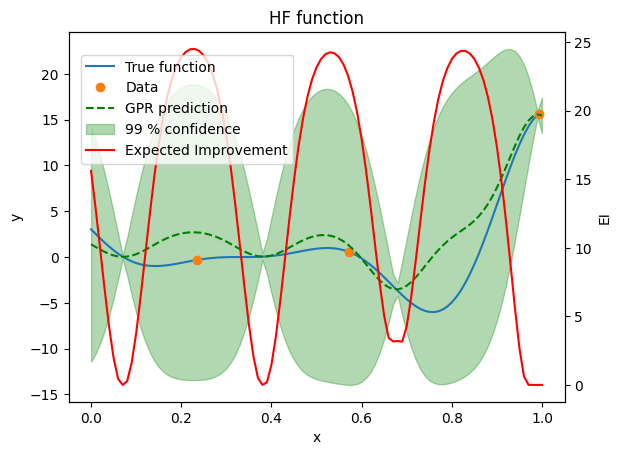

In [99]:
import scipy as sp
from scipy.stats import norm
from scipy.optimize import minimize


def EI(model, points, f_min):
    pred = model.predict_values(points)
    var = model.predict_variances(points)
    args0 = (f_min - pred) / var
    args1 = (f_min - pred) * norm.cdf(args0)
    args2 = var * norm.pdf(args0)

    if var.size == 1 and var == 0.0:  # can be use only if one point is computed
        return 0.0

    ei = args1 + args2
    return ei


# to plot the surrogate
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
#
Y_HF_mean = sm_HF.predict_values(x)
Y_HF_var = sm_HF.predict_variances(x)

# EI prediction
Y_EI = EI(sm_HF, x, np.min(yt_e))


# Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(x, HF_function(x))
(data,) = ax.plot(Xt_e, yt_e, linestyle="", marker="o")
(gp,) = ax.plot(x, Y_HF_mean, linestyle="--", color="g")

un_gp = ax.fill_between(
    np.ravel(x),
    np.ravel(Y_HF_mean - 2 * np.sqrt(Y_HF_var)),
    np.ravel(Y_HF_mean + 2 * np.sqrt(Y_HF_var)),
    alpha=0.3,
    color="g",
)
ax1 = ax.twinx()

(ei,) = ax1.plot(x, Y_EI, color="red")

lines = [true_fun, data, gp, un_gp, ei]
ax.set_title("HF function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax1.set_ylabel("EI")
fig.legend(
    lines,
    [
        "True function",
        "Data",
        "GPR prediction",
        "99 % confidence",
        "Expected Improvement",
    ],
    loc=[0.13, 0.64],
)
plt.show()

Now we compute the EGO method and compare it to other infill criteria 
- SBO (surrogate based optimization): directly using the prediction of the surrogate model ($\mu$)
- EI for expected Improvement (EGO)

In [100]:
# surrogate Based optimization: min the Surrogate model by using the mean value mu
def SBO(GP, point):
    res = GP.predict(point)
    return res

Choose the criterion: SBO or EI

In [101]:
IC = "EI"  # or 'SBO'

We need to find the reference value for optimum  (`SLSQP` algorithm is used from scipy).

In [102]:
x_start = np.atleast_2d(np.random.rand(20)).T

opt_all = np.array(
    [
        minimize(lambda x: float(HF_function(x)), x_st, method="SLSQP", bounds=[(0, 1)])
        for x_st in x_start
    ]
)

opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
ind_min = np.argmin(obj_success)
opt = opt_success[ind_min]
x_et_k = opt["x"]
print(
    "A local optimal point is found in "
    + str(opt["x"])
    + " with the value "
    + str(opt["fun"])
)
print("A SLSQP algorithm from scipy has been used.")

sol_1D = opt["fun"]

A local optimal point is found in [0.75724859] with the value -6.020740055752362
A SLSQP algorithm from scipy has been used.


In [103]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML

Let's apply EGO algorithm and visualize the process

In [ ]:
plt.ioff()

x_data = np.atleast_2d([0, 0.4, 0.9]).T
y_data = HF_function(x_data)
n_iter = 20
sm = KRG(theta0=[1e-2], print_global=False)

# accuracy
k = 0
eps = 1
threshold_accuracy = 1e-3

while eps >= threshold_accuracy and k < n_iter:
    x_start = np.atleast_2d(np.random.rand(20)).T
    f_min_k = np.min(y_data)
    sm.set_training_values(x_data, y_data)
    sm.train()

    if IC == "EI":

        def obj_k(x):
            return -EI(sm, np.atleast_2d(x), f_min_k)  # EI to maximize
    elif IC == "SBO":

        def obj_k(x):
            return SBO(sm, np.atleast_2d(x))  # SBO to minimize

    opt_all = np.array(
        [
            minimize(lambda x: float(obj_k(x)), x_st, method="SLSQP", bounds=[(0, 1)])
            for x_st in x_start
        ]
    )

    opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
    obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt["x"]

    y_et_k = HF_function(x_et_k)

    y_data = np.atleast_2d(np.append(y_data, y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data, x_et_k)).T

    Y_GP_plot_mean = sm.predict_values(x)
    Y_GP_plot_var = sm.predict_variances(x)
    Y_EI_plot = obj_k(x)

    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(111)
    if IC == "SBO":
        (ei,) = ax.plot(x, Y_EI_plot, color="red")
    else:
        ax1 = ax.twinx()
        (ei,) = ax1.plot(x, Y_EI_plot, color="red")
    (true_fun,) = ax.plot(x, HF_function(x))
    (data,) = ax.plot(
        x_data[0 : k + 3], y_data[0 : k + 3], linestyle="", marker="o", color="orange"
    )
    (opt,) = ax.plot(x_data[k + 3], y_data[k + 3], linestyle="", marker="*", color="r")
    (gp,) = ax.plot(x, Y_GP_plot_mean, linestyle="--", color="g")
    un_gp = ax.fill_between(
        np.ravel(x),
        np.ravel(Y_GP_plot_mean - 2 * np.sqrt(Y_GP_plot_var)),
        np.ravel(Y_GP_plot_mean + 2 * np.sqrt(Y_GP_plot_var)),
        alpha=0.3,
        color="g",
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    ax.set_title("HF - function")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(
        lines,
        [
            "True function",
            "Data",
            "GPR prediction",
            "99 % confidence",
            "Next point to Evaluate",
            "Infill Criteria",
        ],
    )
    plt.savefig("Optimization%d" % k)
    plt.close(fig)
    k = k + 1
    ind_best_current = np.argmin(y_data)
    y_opt_current = y_data[ind_best_current]
    eps = np.abs(y_opt_current - sol_1D)
ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print("Results : X = %s, Y = %s" % (x_opt, y_opt))
print("obtained in :", k, " iterations")
print("with accuracy of :", eps)
print(
    "Xopt test 1D ",
    x_opt,
    "with Yopt value=",
    y_opt,
    " obtained using EGO criterion = ",
    IC,
)
print(
    "Check if the optimal point is closed to the reference solution Xopt= (array([0.75724809]), array([-6.020740])"
)
print("---------------------------")

fig = plt.figure(figsize=[10, 10])

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ims = []
for i in range(k):
    image_pt = mpimg.imread("Optimization%d.png" % i)
    im = plt.imshow(image_pt)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500)
HTML(ani.to_jshtml())

Results : X = [0.7567837], Y = [-6.02062471]
obtained in : 8  iterations
with accuracy of : [0.00011534]
Xopt test 1D  [0.7567837] with Yopt value= [-6.02062471]  obtained using EGO criterion =  EI
Check if the optimal point is closed to the reference solution Xopt= (array([0.75724809]), array([-6.020740])
---------------------------


### We can now create a EGO class to be applied to other functions 

In [105]:
class EGO:
    def __init__(self, function, kriging_model, bounds, sol, multi_start=20, eps=1e-3):
        self.km = kriging_model
        self.bounds = bounds
        self.function = function
        self.doe_x = self.km.training_points[None][0][0]
        self.doe_y = self.km.training_points[None][0][1]
        self.dim = self.km.nx
        self.corr_fun = self.km.options["corr"]
        self.multi_start = multi_start
        self.y0_best = np.min(self.doe_y)
        self.sol = sol
        self.eps = eps

    def compute_EI(self, x):
        # compute expected improvement at point x
        x = np.atleast_2d(x)
        Y_min = np.min(self.km.training_points[None][0][1])
        y_pred = self.km.predict_values(x)
        mse = self.km.predict_variances(x)
        y_pred = np.atleast_2d(y_pred)
        sigma_y = np.sqrt(mse)
        y_normed = (Y_min - y_pred[:, 0]) / sigma_y
        EI = (Y_min - y_pred[:, 0]) * sp.stats.norm.cdf(
            y_normed
        ) + sigma_y * sp.stats.norm.pdf(y_normed)
        return -np.ravel(EI)

    def run(self, budget):
        self.current_cost = 0
        n_iter = 0
        epsilon = 1
        doe_init_size_HF = len(self.doe_y)
        while self.current_cost < budget and epsilon >= self.eps:
            n_iter = n_iter + 1
            # optimization of the EI
            candidat = []
            value = []
            X0 = np.random.rand(self.multi_start, self.dim)
            for i in range(len(self.bounds)):
                X0[:, i] = (
                    X0[:, i] * (-self.bounds[i, 0] + self.bounds[i, 1])
                    + self.bounds[i, 0]
                )
            # Multi start
            for x in X0:
                new_point = sp.optimize.fmin_slsqp(
                    self.compute_EI, np.atleast_2d(x), bounds=self.bounds, iprint=0
                )
                candidat.append(new_point)
                value.append(self.compute_EI(new_point))
            value = np.array(value)

            ind_min = value.argmin()
            x_n = candidat[ind_min].reshape((1, self.dim))

            # Evaluation of the true function(s)
            y_n = self.function(x_n)
            y_n = np.atleast_2d(y_n)

            # updating the kriging meta-model
            self.doe_x = np.append(self.doe_x, x_n, axis=0)
            self.doe_y = np.append(self.doe_y, y_n, axis=0)
            self.km.set_training_values(self.doe_x, self.doe_y)
            # retraining the model
            self.km.train()
            # distance criterion
            epsilon = np.abs(np.min(self.doe_y) - self.sol)
            print("######################################")
            print("Iteration n=", n_iter)
            print(
                "Number of Hi Fi calls during optimization= ",
                len(self.doe_y) - doe_init_size_HF,
            )

            print("max EI found at x=", x_n)
            print(
                "Current best value=",
                np.min(self.doe_y),
                " distance to reference solution: ",
                epsilon,
            )
            print("Value of the EI =", value.min())
            self.current_cost = self.current_cost + 1
            # add total budget + dif 1D/1D

        Y_min = np.min(self.doe_y)
        return Y_min, self.km, self.doe_x, self.doe_y

Let's try it on the analytical function.

In [106]:
from smt.sampling_methods import LHS

In [107]:
dim = 1
n = 3  # number of high fidelity points (number of low fi is twice)
nlevel = 2
ub0 = 1.0
lb0 = 0.0

xlimits = np.array([[lb0, ub0]])

xdoes = LHS(xlimits=xlimits)
Xe = xdoes(n)
ye = HF_function(Xe)

sm = KRG(print_global=False)
sm.set_training_values(Xe, ye)
sm.train()

algo_EGO = EGO(HF_function, sm, bounds=xlimits, sol=sol_1D)
# Running the EGO algorithm for n_iter
budget = 10
Y_min, sm, doe_x, doe_y = algo_EGO.run(budget)

######################################
Iteration n= 1
Number of Hi Fi calls during optimization=  1
max EI found at x= [[0.87936729]]
Current best value= -2.5147394837903327  distance to reference solution:  3.506000571962029
Value of the EI = -0.20685006147213209
######################################
Iteration n= 2
Number of Hi Fi calls during optimization=  2
max EI found at x= [[0.79351362]]
Current best value= -5.257686225505456  distance to reference solution:  0.7630538302469061
Value of the EI = -1.7544912435354874
######################################
Iteration n= 3
Number of Hi Fi calls during optimization=  3
max EI found at x= [[0.74719782]]
Current best value= -5.968398011480952  distance to reference solution:  0.05234204427140998
Value of the EI = -0.2040971452397623
######################################
Iteration n= 4
Number of Hi Fi calls during optimization=  4
max EI found at x= [[0.67170208]]
Current best value= -5.968398011480952  distance to reference solution: 

In [108]:
print("EGO results: ")
print("Total number of Hi Fi computations (including DOE): ", len(doe_y))

EGO results: 
Total number of Hi Fi computations (including DOE):  10



<div class="alert alert-info">
    SMT toolbox also provides EGO algorithm
(see https://smt.readthedocs.io/en/latest/_src_docs/applications/ego.html).  You could apply it to the analytical function.
</div>


Minimum in x=0.757 with f(x)=-6.021


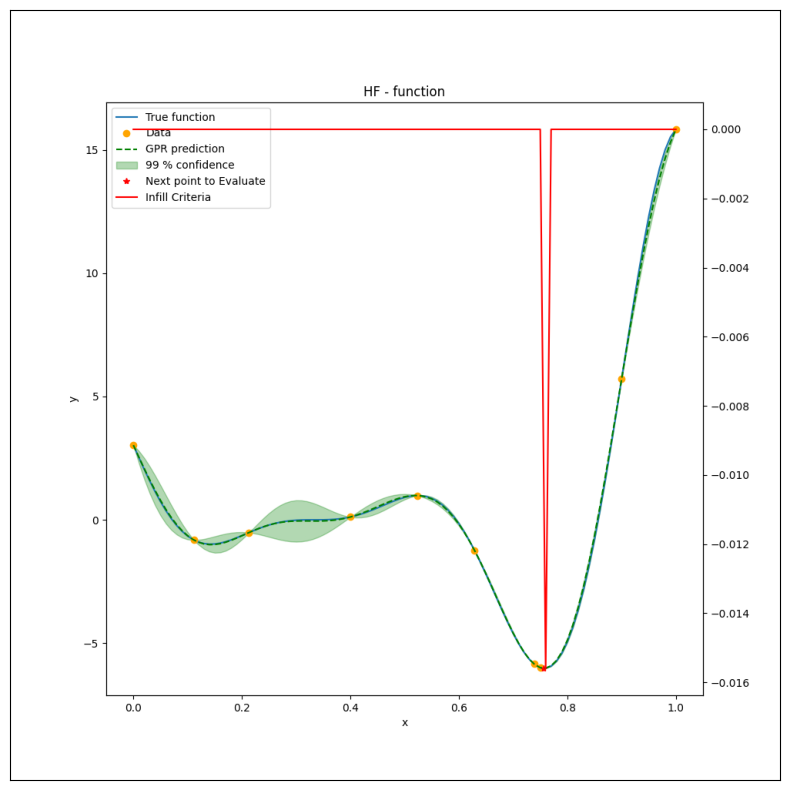

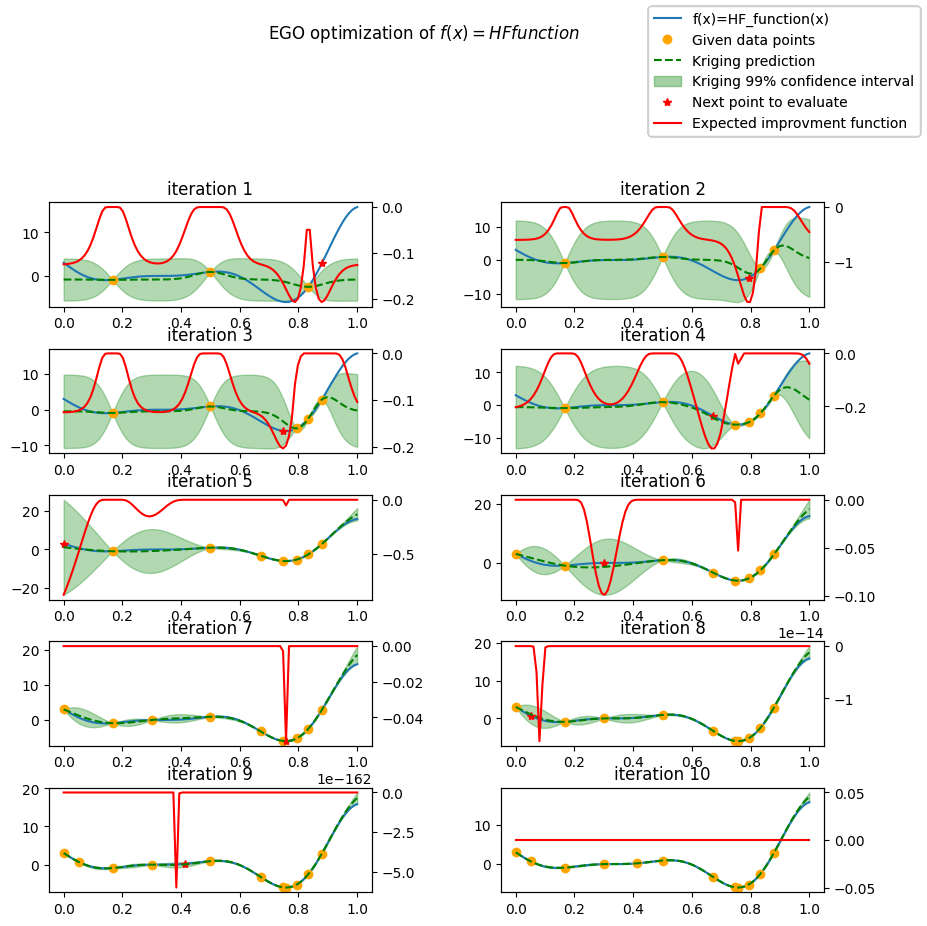

In [109]:
from smt.applications import EGO as EGO_SMT
from smt.design_space import DesignSpace

n_iter = 10
xlimits = np.array([[0.0, 1.0]])
xdoes = LHS(xlimits=xlimits)
xdoe = xdoes(n)
n_doe = xdoe.size

criterion = "EI"  #'EI' or 'SBO' or 'LCB'
design_space = DesignSpace(xlimits)
ego = EGO_SMT(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=HF_function)
print("Minimum in x={:.3f} with f(x)={:.3f}".format(float(x_opt), float(y_opt)))

x_plot = np.atleast_2d(np.linspace(0, 1, 100)).T
y_plot = HF_function(x_plot)

fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()

    y_gp_plot = ego.gpr.predict_values(x_plot)
    y_gp_plot_var = ego.gpr.predict_variances(x_plot)
    y_ei_plot = -ego.EI(x_plot)

    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(x_plot, y_plot)
    (data,) = ax.plot(x_data_k, y_data_k, linestyle="", marker="o", color="orange")
    if i < n_iter - 1:
        (opt,) = ax.plot(x_data[k], y_data[k], linestyle="", marker="*", color="r")
    (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of $f(x) = HF function$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=HF_function(x)",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvment function",
        ],
    )
plt.show()

### 2.2 MFEGO (multi fidelity)

#### MFEGO:

MFEGO is a two-step decision process:
1. fix most promising point: EI criterion
2. choose levels of enrichment: trade-off information gain/cost
    
By using low-fidelity to reduce the uncertainty we reduce the Exploration contribution to the EI criterion. High-fidelity is used for Exploitation and model enhancement

We compute the uncertainty reduction as: 
\begin{equation*}
\sigma_{red}^{2}(k,x^*) = \sum_{i=0}^k \sigma_{\delta,i}^{2}(x^*) \prod_{j=i}^{l-1} \rho^2_j
\end{equation*}

In [110]:
def ME(lvl, sigma_delta, sigma_rho, theta_vol_lvl, costs, last_val=0):
    """
    ME : Model enhancement criterion
    """

    MSE_r = last_val + sigma_delta[lvl] * np.prod(sigma_rho[lvl:]) * theta_vol_lvl[lvl]
    if last_val == 0:
        return True, MSE_r

    return np.log(MSE_r) - np.log(last_val) > 2.0 * np.log(
        1 + costs[lvl] / costs[lvl - 1]
    ), MSE_r

In [111]:
class MFEGO:
    """
    Attributes :
        functions, functions from lowest to highest level
    """

    def __init__(
        self, functions, kriging_model, bounds, costs, sol, multi_start=20, eps=1e-3
    ):
        self.km = kriging_model
        self.bounds = bounds
        self.n_lvls = 2
        if self.n_lvls != len(functions):
            raise Exception(
                "There must be as many functions as fidelity levels in your Kriging model"
            )
        if self.n_lvls != len(costs):
            raise Exception(
                "There must be as many costs as fidelity levels in your Kriging model"
            )

        self.levels = [0, None]  ## Highest level has the name None for smt
        self.functions = {0: functions[0], None: functions[1]}
        self.doe_x = {
            0: self.km.training_points[0][0][0],
            None: self.km.training_points[None][0][0],
        }
        self.doe_y = {
            0: self.km.training_points[0][0][1],
            None: self.km.training_points[None][0][1],
        }
        self.dim = self.km.nx
        self.costs = np.array(costs) + 0.0
        self.gain = []
        self.cost_hist = []
        self.corr_fun = self.km.options["corr"]
        self.multi_start = multi_start
        self.y0_best = np.min(self.doe_y[None])
        self.sol = sol
        self.eps = eps

    def cost_increment(self, lvls_added):
        # computing the cost increment after each iteration
        # lvls_added list of booleans, True if to be added, False otherwise
        return np.sum(lvls_added * self.costs) / self.costs[-1]

    def compute_EI(self, x):
        # compute expected improvement at point x
        x = np.atleast_2d(x)
        Y_min = np.min(self.km.training_points[None][0][1])
        y_pred = self.km.predict_values(x)
        mse = self.km.predict_variances(x)
        y_pred = np.atleast_2d(y_pred)
        sigma_y = np.sqrt(mse)
        y_normed = (Y_min - y_pred[:, 0]) / sigma_y
        EI = (Y_min - y_pred[:, 0]) * sp.stats.norm.cdf(
            y_normed
        ) + sigma_y * sp.stats.norm.pdf(y_normed)

        return -np.ravel(EI)

    def add_level(self, x):
        MSE, sigma_rho = self.km.predict_variances_all_levels(x)

        sigma_delta = np.zeros((self.n_lvls,))
        sigma_rho = np.array(sigma_rho)
        theta_vol_lvl = np.ones((self.n_lvls,))
        flags = self.n_lvls * [False]
        for lvl in self.levels:
            if lvl is None:
                lvl = self.n_lvls - 1

            theta_vol_lvl[lvl] = 1.0
            if lvl == 0:
                sigma_delta[lvl] = MSE[0, 0]
                flags[lvl], val = ME(
                    lvl, sigma_delta, sigma_rho, theta_vol_lvl, self.costs
                )
            else:
                sigma_delta[lvl] = MSE[0, lvl] - (MSE[0, lvl - 1]) * sigma_rho[lvl - 1]
                flags[lvl], val = ME(
                    lvl, sigma_delta, sigma_rho, theta_vol_lvl, self.costs, last_val=val
                )
            if not flags[lvl]:
                break

        return flags

    def run(self, budget):
        self.current_cost = 0
        n_iter = 0
        epsilon = 1
        doe_init_size_HF = len(self.doe_y[None])
        doe_init_size_LF = len(self.doe_y[0])
        init_cost = len(sm.training_points[0][0][1]) / self.costs[-1] + len(
            sm.training_points[None][0][1]
        )
        while self.current_cost < budget and epsilon >= self.eps:
            n_iter = n_iter + 1
            # optimization of the EI
            candidat = []
            value = []
            X0 = np.random.rand(self.multi_start, self.dim)

            for i in range(len(self.bounds)):
                X0[:, i] = (
                    X0[:, i] * (-self.bounds[i, 0] + self.bounds[i, 1])
                    + self.bounds[i, 0]
                )
            # Multi start
            for x in X0:
                new_point = sp.optimize.fmin_slsqp(
                    self.compute_EI, np.atleast_2d(x), bounds=self.bounds, iprint=0
                )
                candidat.append(new_point)
                value.append(self.compute_EI(new_point))
            value = np.array(value)

            ind_min = value.argmin()
            x_n = candidat[ind_min].reshape((1, self.dim))
            # Evaluation of the true function(s)
            levels_to_be_added = self.add_level(x_n)

            for lvl in self.levels:
                ll = lvl if lvl is not None else -1
                if levels_to_be_added[ll]:  ## level infill criterion
                    y_n = self.functions[lvl](x_n)
                    y_n = np.atleast_2d(y_n)
                    # updating the kriging meta-model
                    self.doe_x[lvl] = np.insert(self.doe_x[lvl], 0, x_n, axis=0)
                    self.doe_y[lvl] = np.insert(self.doe_y[lvl], 0, y_n, axis=0)
                    self.km.set_training_values(
                        self.doe_x[lvl], self.doe_y[lvl], name=lvl
                    )
            # retraining the model
            self.km.train()

            # computing cost increment
            self.current_cost = self.current_cost + self.cost_increment(
                levels_to_be_added
            )

            # saving data for visualization and postprocesing
            self.cost_hist.append(self.current_cost)
            self.gain.append(self.y0_best - np.min(self.doe_y[None]))
            epsilon = np.abs(np.min(self.doe_y[None]) - self.sol)
            print("######################################")
            print("iteration n=", n_iter)
            print(
                "Number of Hi Fi calls during optimization= ",
                len(self.doe_y[None]) - doe_init_size_HF,
            )
            print(
                "Number of Low Fi calls during optimization= ",
                len(self.doe_y[0]) - doe_init_size_LF,
            )
            print("max EI found at x=", x_n)
            print(
                "Current best value=",
                np.min(self.doe_y[None]),
                " distance to reference solution: ",
                epsilon,
            )
            print("value of the EI =", value.min())
            print(
                "Enrichement current spent budget: ",
                self.current_cost,
                " Total cost including DOE: ",
                self.current_cost + init_cost,
            )
            # add total budget + dif 1D/1D

        Y_min = np.min(self.doe_y[None])
        return Y_min, self.km, self.doe_x, self.doe_y

Let's apply it to the 2 analytical functions (LF and HF).

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from smt.applications import MFK

from smt.applications.mfk import NestedLHS

dim = 1
n = 3  # number of high fidelity points (number of low fi is twice)
nlevel = 2
ub0 = 1.0
lb0 = 0.0

xlimits = np.array([[lb0, ub0]])

costs = np.array([1, 100])  # low and high-fidelity costs
# initial_cost = np.sum(np.array(n)*costs)

# np.random.seed(1)
# To create the nested DOE
xdoes = NestedLHS(nlevel=nlevel, xlimits=xlimits)
Xc, Xe = xdoes(n)


yc = LF_function(Xc)
ye = HF_function(Xe)

# time.sleep(5)

sm = MFK(theta0=Xt_e.shape[1] * [1.0], print_global=False)
sm.set_training_values(Xc, yc, name=0)
sm.set_training_values(Xe, ye)
sm.train()

bounds = np.array([[lb0, ub0]])
algo_MFEGO = MFEGO([LF_function, HF_function], sm, bounds, costs=costs, sol=sol_1D)
# Running the EGO algorithm for n_iter
budget = 10
Y_min, sm, doe_x, doe_y = algo_MFEGO.run(budget)

target_level = algo_MFEGO.levels[-1]

######################################
iteration n= 1
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  1
max EI found at x= [[0.72419902]]
Current best value= -5.0147967054536045  distance to reference solution:  1.0059433502987574
value of the EI = -3.6673056912751445
Enrichement current spent budget:  0.01  Total cost including DOE:  3.07
######################################
iteration n= 2
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  2
max EI found at x= [[0.75679384]]
Current best value= -5.0147967054536045  distance to reference solution:  1.0059433502987574
value of the EI = -0.967737435520303
Enrichement current spent budget:  0.02  Total cost including DOE:  3.08
######################################
iteration n= 3
Number of Hi Fi calls during optimization=  1
Number of Low Fi calls during optimization=  3
max EI found at x= [[0.75714735]]
Current best value= -6.020734565930456  distance t

In [113]:
print(" MFEGO results: ")
print("Total number of Hi Fi computations (including DOE): ", len(doe_y[None]))
print("Total number of Low Fi computations (including DOE): ", len(doe_y[0]))

 MFEGO results: 
Total number of Hi Fi computations (including DOE):  4
Total number of Low Fi computations (including DOE):  9


## 3- Optimization - 2D


We are now going to study the convergence of the MFEGO algorithm in a multimodal function, the Branin function. The parameter $A_{corr}$ allows to modify the correlation between the function of HF and the function of LF, $$A_{corr} \in [0, 1]$$

The function of Branin, as well as its low fidelity version, are  both defined as follows
\begin{align}
    y_{HF3Opt} & = \left(x_2 - \dfrac{5.1}{4\pi^2}x_1^2 + \dfrac{5}{\pi}x_1 - 6\right)^2 + 10 \left(1 - \dfrac{1}{8\pi}\right)\cos(x_1) + 10\\
    y_{HF1Opt} & = y_{HF} + 5x_1 \\
    y_{LF} & = y_{HF3Opt} - (0.5A_{corr}^2 + A_{corr} + 0.2)\left(x_2 - \dfrac{5.1}{4\pi^2}x_1^2 + \dfrac{5}{\pi}x_1 - 6 \right)^2,
  \qquad  x_1 \in [−5, 10]  \mbox{ and }  x_2 \in [0, 15] 
\end{align}

where $y_{HF3Opt}$ represents the original function with 3 global optimal points, and $y_{HF1Opt}$ represents a variation of the function that presents 2 local optimal points and only 1 global.

The same function of Branin LF as the one presented in the following article has been used

>*A radial basis function-based multi-fidelity surrogate model: exploring correlation between high-fidelity and low-fidelity models.* Structural and Multidisciplinary Optimization. 01/04/2019. Xueguan Song, Liye Lv, Wei Sun, Jie Zhang. https://doi.org/10.1007/s00158-019-02248-0

### 3.1 EGO in a 2D function with 3 local minima - Branin function

In [114]:
def Branin_HF(point):
    # Expensive Branin function
    res = (
        (
            point[:, 1]
            - (5.1 / (4 * np.pi**2)) * point[:, 0] ** 2
            + (5 / np.pi) * point[:, 0]
            - 6
        )
        ** 2
        + 10 * (1 - (1 / 8 / np.pi)) * np.cos(point[:, 0])
        + 10
        + 5 * point[:, 0]
    )
    return res


def Branin_LF(point):
    global A_corr
    # Cheap Branin function
    res = (
        Branin_HF(point)
        - (0.5 * A_corr**2 + A_corr + 0.2)
        * (
            point[:, 1]
            - 5.1 / 4 / np.pi**2 * point[:, 0] ** 2
            + 5 / np.pi * point[:, 0]
            - 6
        )
        ** 2
    )
    return res

In [115]:
from matplotlib import cm

A_corr = -1
num = 100
x = np.linspace(-5.0, 10.0, num)
y = np.linspace(0.0, 15.0, num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num * num, 1])
z_HF = Branin_HF(x_test)

fig1 = plt.figure()
axSurrogate1 = fig1.add_subplot(111)
axSurrogate1.set_title("HF function")
surf1 = axSurrogate1.contour(
    xv, yv, z_HF.reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig1.colorbar(surf1)
fig1.show()
#
num = 100
x = np.linspace(-5.0, 10.0, num)
y = np.linspace(0.0, 15.0, num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_LF = np.zeros([num * num, 1])
z_LF = Branin_LF(x_test)
fig2 = plt.figure()
axSurrogate2 = fig2.add_subplot(111)
axSurrogate2.set_title("LF function")
surf2 = axSurrogate2.contour(
    xv, yv, z_LF.reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig2.colorbar(surf2)
fig2.show()

We need to have the reference for optimum. `SLSQP` from scipy is used to get a reference solution.

In [116]:
x0_Branin = x0_Branin = [-3.5, 14]  # np.atleast_2d([-3.5, 14])

Bound_Branin = ((-5, 10), (0, 15))
res = minimize(
    lambda x: float(Branin_HF(np.atleast_2d(x))),
    x0_Branin,
    method="SLSQP",
    bounds=Bound_Branin,
)
#
print(
    "A local optimal point with initial conditions "
    + str(x0_Branin)
    + " is found in "
    + str(res.x)
    + " with the value "
    + str(res.fun)
)
print("A SLSQP algorithm from scipy has been used.")
sol_Branin = res.fun

A local optimal point with initial conditions [-3.5, 14] is found in [-3.68930439 13.63004733] with the value -16.644021569225643
A SLSQP algorithm from scipy has been used.


Using EGO class

In [117]:
dim = 2
n = 5  # number of doe points
nlevel = 2
ub0 = 10.0
ub1 = 15.0
lb0 = -5.0
lb1 = 0.0
xlimits = np.array([[lb0, ub0], [lb1, ub1]])

# To create the nested DOE
xdoes = LHS(xlimits=xlimits)
Xe = xdoes(n)
ye = Branin_HF(Xe)

sm = KRG(print_global=False)
sm.set_training_values(Xe, ye)
sm.train()

bounds = np.array([[lb0, ub0], [lb1, ub1]])
algo_EGO = EGO(Branin_HF, sm, bounds, sol=sol_Branin)
# Running the EGO algorithm for n_iter=budget
budget = 30
Y_min, sm, doe_x, doe_y = algo_EGO.run(budget)

######################################
Iteration n= 1
Number of Hi Fi calls during optimization=  1
max EI found at x= [[6.77809786e+00 1.11022302e-16]]
Current best value= 16.378135404532262  distance to reference solution:  33.0221569737579
Value of the EI = -2.154876838941188
######################################
Iteration n= 2
Number of Hi Fi calls during optimization=  2
max EI found at x= [[9.17423658 8.0980203 ]]
Current best value= 16.378135404532262  distance to reference solution:  33.0221569737579
Value of the EI = -2.737000515390446
######################################
Iteration n= 3
Number of Hi Fi calls during optimization=  3
max EI found at x= [[2.98579419 5.59610002]]
Current best value= 16.378135404532262  distance to reference solution:  33.0221569737579
Value of the EI = -9.483444410426898
######################################
Iteration n= 4
Number of Hi Fi calls during optimization=  4
max EI found at x= [[-5.         9.2686495]]
Current best value= 16.37813540

In [118]:
print("Branin - EGO results: ")
print("Total number of Hi Fi computations (including DOE): ", len(doe_y))

Branin - EGO results: 
Total number of Hi Fi computations (including DOE):  35


Let's visualize the enrichment process.

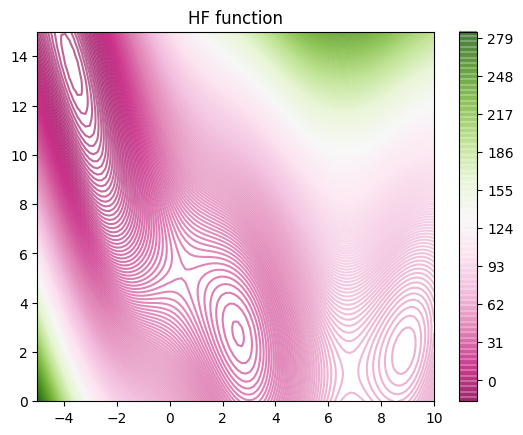

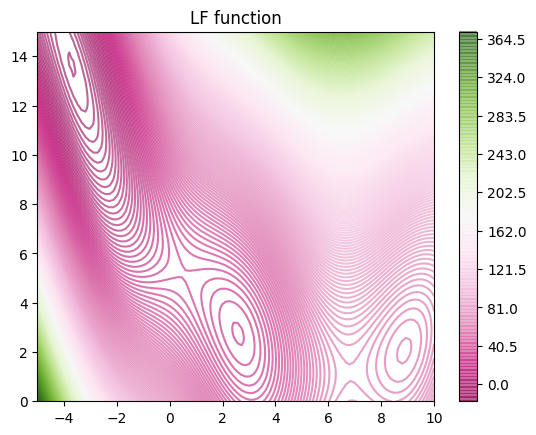

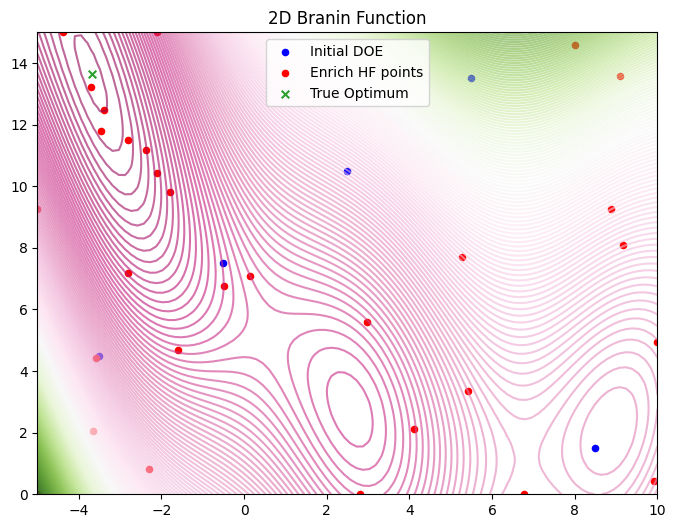

In [119]:
doe_size = n
doe = doe_x
response = doe_y

doe_LF = []
response_HF = []

doe_HF = doe
response_HF = response

num = 100
x = np.linspace(-5.0, 10.0, num)
y = np.linspace(0.0, 15.0, num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num * num, 1])

z_HF = Branin_HF(x_test)
fig1 = plt.figure(figsize=(8, 6))
axSurrogate1 = fig1.add_subplot(111)
surf1 = axSurrogate1.contour(
    xv, yv, z_HF.reshape((num, num)), 150, cmap=cm.PiYG, antialiased=True, alpha=0.6
)

scatter2 = axSurrogate1.scatter(
    doe_HF.T[0][0:doe_size], doe_HF.T[1][0:doe_size], s=20.0, c="b", label="Initial DOE"
)
scatter2 = axSurrogate1.scatter(
    doe_HF.T[0][doe_size:],
    doe_HF.T[1][doe_size:],
    s=20.0,
    c="r",
    label="Enrich HF points",
)
scatter3 = axSurrogate1.scatter(
    -3.68930439, 13.63004733, s=30.0, marker="x", c="C2", label="True Optimum"
)
axSurrogate1.set_xlim([-5, 10])
axSurrogate1.set_ylim([0, 15])
axSurrogate1.set_title(r"2D Branin Function", fontsize=12)
axSurrogate1.legend()
plt.show()

### 3.2 MFEGO applied to Branin 2D

### <font color='blue'> Exercice:  Create and run the MFEGO problem for Branin 2D </font>

In [120]:
dim = 2
n = 5  # number of high fidelity points (number of low fi is twice)
nlevel = 2
ub0 = 10.0
ub1 = 15.0
lb0 = -5.0
lb1 = 0.0
xlimits = np.array([[lb0, ub0], [lb1, ub1]])
costs = np.array([1, 10])  # low and high-fidelity costs
initial_cost = np.sum(np.array(n) * costs)

# To create the nested DOE
xdoes = NestedLHS(nlevel=nlevel, xlimits=xlimits)
Xc, Xe = xdoes(n)

yc = Branin_LF(Xc)
ye = Branin_HF(Xe)

sm = MFK(print_global=False)
sm.set_training_values(Xc, yc, name=0)
sm.set_training_values(Xe, ye)
sm.train()

algo_MFEGO = MFEGO(
    [Branin_LF, Branin_HF], sm, bounds=xlimits, costs=costs, sol=sol_Branin
)

# Running the EGO algorithm for a fixed budget
budget = 10
Y_min, sm, doe_x, doe_y = algo_MFEGO.run(budget)

######################################
iteration n= 1
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  1
max EI found at x= [[-4.08273012  7.6872355 ]]
Current best value= 6.912629981437892  distance to reference solution:  23.556651550663535
value of the EI = -6.386015406923991
Enrichement current spent budget:  0.1  Total cost including DOE:  6.1
######################################
iteration n= 2
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  2
max EI found at x= [[-2.082419    7.81893586]]
Current best value= 6.912629981437892  distance to reference solution:  23.556651550663535
value of the EI = -5.632346785963073
Enrichement current spent budget:  0.2  Total cost including DOE:  6.2
######################################
iteration n= 3
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  3
max EI found at x= [[-2.23219406  7.66251988]]
Current best value= 

## 3.3  Try with another  2D function: 2D Rosenbrock function 


Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$
    

In [121]:
def Rosen_HF(point):
    # Expensive Rosen function

    res = (1.0 - point[:, 0]) ** 2 + 100 * (point[:, 1] - point[:, 0] ** 2) ** 2
    return res


def Rosen_LF(point):
    # Expensive Rosen function

    res = (
        (1.0 - point[:, 0]) ** 2
        + 100 * (point[:, 1] - point[:, 0] ** 2) ** 2
        + 0.1 * np.sin(10 * point[:, 0] + 5 * point[:, 1])
    )

    return res

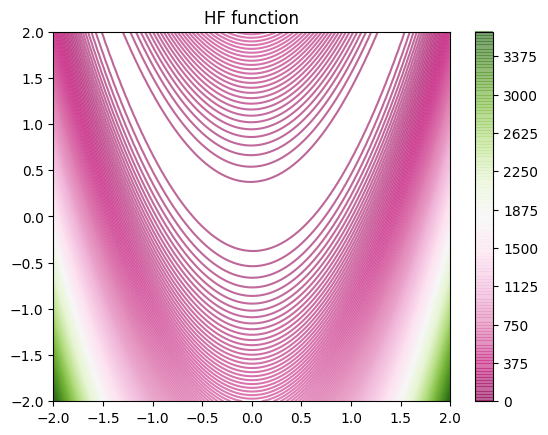

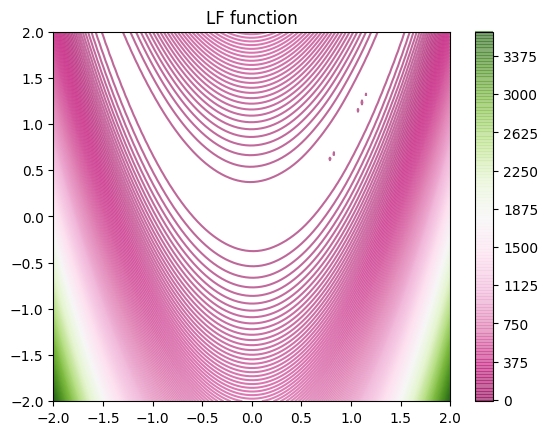

In [122]:
num = 100
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num * num, 1])
z_HF = Rosen_HF(x_test)

fig1 = plt.figure()
axSurrogate1 = fig1.add_subplot(111)
axSurrogate1.set_title("HF function")
surf1 = axSurrogate1.contour(
    xv, yv, z_HF.reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig1.colorbar(surf1)
fig1.show()
#
num = 100
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_LF = np.zeros([num * num, 1])
z_LF = Rosen_LF(x_test)

fig2 = plt.figure()
axSurrogate2 = fig2.add_subplot(111)
axSurrogate2.set_title("LF function")
surf2 = axSurrogate2.contour(
    xv, yv, z_LF.reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig2.colorbar(surf2)
plt.show()

Finding the optimum.

### <font color='blue'>Exercice:  find the optimum for Rosen using the minimize with SLSQP </font>

In [123]:
x0_Rosen = [-0, 0]

Bound_Rosen = ((-2, 2), (-2, 2))
res = minimize(
    lambda x: float(Rosen_HF(np.atleast_2d(x))),
    x0_Rosen,
    method="SLSQP",
    bounds=Bound_Rosen,
)

print(
    "A local optimal point with initial conditions "
    + str(x0_Rosen)
    + " is found in "
    + str(res.x)
    + " with the value "
    + str(res.fun)
)
print("A SLSQP algorithm from scipy has been used")
sol_Rosen = res.fun

A local optimal point with initial conditions [0, 0] is found in [0.99977559 0.9995554 ] with the value 5.208667646927756e-08
A SLSQP algorithm from scipy has been used


Using EGO

### <font color='blue'>Exercice:  Optimize Rosen with EGO </font>

######################################
Iteration n= 1
Number of Hi Fi calls during optimization=  1
max EI found at x= [[-0.03522793  1.75060415]]
Current best value= 44.19999999999996  distance to reference solution:  44.199999947913284
Value of the EI = -238.25636310479706
######################################
Iteration n= 2
Number of Hi Fi calls during optimization=  2
max EI found at x= [[-0.91106243 -1.70891691]]
Current best value= 44.19999999999996  distance to reference solution:  44.199999947913284
Value of the EI = -158.61024390020015
######################################
Iteration n= 3
Number of Hi Fi calls during optimization=  3
max EI found at x= [[0.02483297 0.19436821]]
Current best value= 4.704916332845643  distance to reference solution:  4.704916280758967
Value of the EI = -188.76615399858338
######################################
Iteration n= 4
Number of Hi Fi calls during optimization=  4
max EI found at x= [[-0.66245792  2.        ]]
Current best value= 4.704916

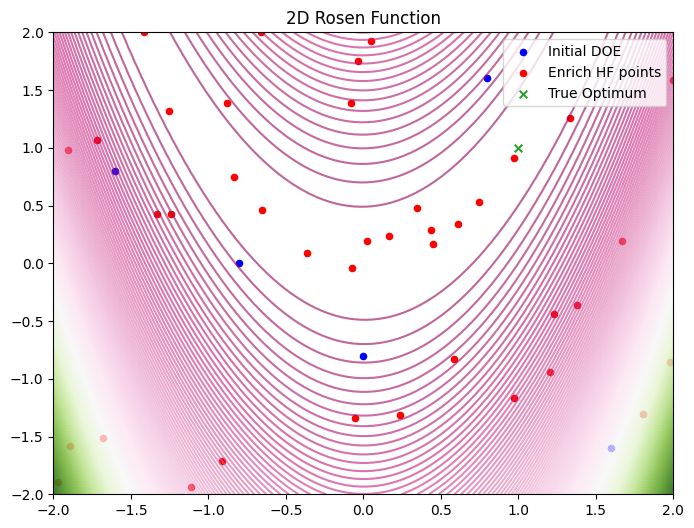

In [124]:
dim = 2
n = 5  # number of doe points
nlevel = 2
ub0 = 2.0
ub1 = 2.0
lb0 = -2.0
lb1 = -2.0
xlimits = np.array([[lb0, ub0], [lb1, ub1]])

# To create the nested DOE
xdoes = LHS(xlimits=xlimits)
Xe = xdoes(n)
ye = Rosen_HF(Xe)


sm = KRG(print_global=False)
sm.set_training_values(Xe, ye)
sm.train()

algo_EGO = EGO(Rosen_HF, sm, bounds=xlimits, sol=sol_Rosen)
# Running the EGO algorithm for niter=budget
budget = 40
Y_min, sm, doe_x, doe_y = algo_EGO.run(budget)


doe = doe_x
response = doe_y

n = doe_size
doe_LF = []
response_HF = []
doe_HF = doe
response_HF = response

num = 100
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num * num, 1])
z_HF = Rosen_HF(x_test)
fig1 = plt.figure(figsize=(8, 6))
axSurrogate1 = fig1.add_subplot(111)
surf1 = axSurrogate1.contour(
    xv, yv, z_HF.reshape((num, num)), 150, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
scatter2 = axSurrogate1.scatter(
    doe_HF.T[0][0:doe_size], doe_HF.T[1][0:doe_size], s=20.0, c="b", label="Initial DOE"
)
scatter2 = axSurrogate1.scatter(
    doe_HF.T[0][doe_size:],
    doe_HF.T[1][doe_size:],
    s=20.0,
    c="r",
    label="Enrich HF points",
)
scatter3 = axSurrogate1.scatter(1, 1, s=30.0, marker="x", c="C2", label="True Optimum")
axSurrogate1.set_xlim([-2, 2])
axSurrogate1.set_ylim([-2, 2])
axSurrogate1.set_title(r"2D Rosen Function", fontsize=12)
axSurrogate1.legend()
plt.show()

Using MFEGO


### <font color='blue'>Exercice:  Optimize Rosen with MFEGO </font>

######################################
iteration n= 1
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  1
max EI found at x= [[0.45458844 0.13578786]]
Current best value= 1.9150268311855927  distance to reference solution:  1.9150267790989162
value of the EI = -172.56994983862035
Enrichement current spent budget:  0.5  Total cost including DOE:  10.5
######################################
iteration n= 2
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  2
max EI found at x= [[-0.52541186  1.08980705]]
Current best value= 1.9150268311855927  distance to reference solution:  1.9150267790989162
value of the EI = -102.50616166551637
Enrichement current spent budget:  1.0  Total cost including DOE:  11.0
######################################
iteration n= 3
Number of Hi Fi calls during optimization=  0
Number of Low Fi calls during optimization=  3
max EI found at x= [[1.28041064 2.        ]]
Current best value

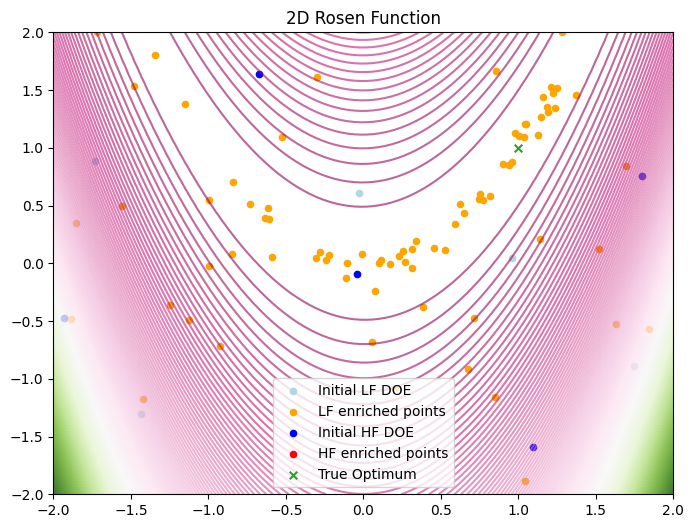

In [125]:
dim = 2
n = 5  # number of high fidelity points (number of low fi is twice)
nlevel = 2
ub0 = 2.0
ub1 = 2.0
lb0 = -2.0
lb1 = -2.0
xlimits = np.array([[lb0, ub0], [lb1, ub1]])

costs = np.array([1, 2])  # low and high-fidelity costs
initial_cost = np.sum(np.array(n) * costs)
# np.random.seed(1)
# To create the nested DOE
xdoes = NestedLHS(nlevel=nlevel, xlimits=xlimits)
Xc, Xe = xdoes(n)


yc = Rosen_LF(Xc)
ye = Rosen_HF(Xe)


sm = MFK(print_global=False)
sm.set_training_values(Xc, yc, name=0)
sm.set_training_values(Xe, ye)
sm.train()

bounds = np.array([[lb0, ub0], [lb1, ub1]])
algo_EGO = MFEGO([Rosen_LF, Rosen_HF], sm, bounds, costs=costs, sol=sol_Rosen)
# Running the MFEGO algorithm for a fixed budget
budget = 40
Y_min, sm, doe_x, doe_y = algo_EGO.run(budget)

doe = doe_x
response = doe_y

doe_LF = []
doe_HF = []
response_LF = []
response_HF = []

doe_HF = doe[None]
doe_LF = doe[0]
response_HF = response[None]
response_LF = response[0]


num = 100
x = np.linspace(-2.0, 2.0, num)
y = np.linspace(-2.0, 2.0, num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num * num, 1])
z_HF = Rosen_HF(x_test)
fig1 = plt.figure(figsize=(8, 6))
axSurrogate1 = fig1.add_subplot(111)
surf1 = axSurrogate1.contour(
    xv, yv, z_HF.reshape((num, num)), 150, cmap=cm.PiYG, antialiased=True, alpha=0.6
)

scatter2 = axSurrogate1.scatter(
    doe_LF.T[0][-2 * n :],
    doe_LF.T[1][-2 * n :],
    s=20.0,
    c="lightblue",
    label="Initial LF DOE",
)
scatter1 = axSurrogate1.scatter(
    doe_LF.T[0][0 : -2 * n],
    doe_LF.T[1][0 : -2 * n],
    s=20.0,
    c="orange",
    label="LF enriched points",
)
scatter2 = axSurrogate1.scatter(
    doe_HF.T[0][-n:], doe_HF.T[1][-n:], s=20.0, c="b", label="Initial HF DOE"
)
scatter2 = axSurrogate1.scatter(
    doe_HF.T[0][0:-n], doe_HF.T[1][0:-n], s=20.0, c="red", label="HF enriched points"
)
scatter3 = axSurrogate1.scatter(1, 1, s=30.0, c="C2", marker="x", label="True Optimum")
axSurrogate1.set_xlim([-2, 2])
axSurrogate1.set_ylim([-2, 2])
axSurrogate1.set_title(r"2D Rosen Function", fontsize=12)
axSurrogate1.legend()
plt.show()